In [2]:
source("../R/process_slim_output.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [43]:
options(repr.plot.width=12, repr.plot.height=4)

## Comparison of Neanderthal- and modern human-specific deleterious variants

In [52]:
slim_file <- read_slim_file("../simulations/exome_and_sites__h_0.5__seed_6977220333793.txt")

Read mutations that occured on the Neanderthal lineage:

In [53]:
nea_mut <- read_mutations(slim_file, "m0", "p2") %>% mutate(freq=freq / (2 * 1000))

Read mutations that occured on the modern human lineage after the split from Neanderthals:

In [54]:
mh_mut <- read_mutations(slim_file, "m0", "p1", t=50000) %>% mutate(freq=freq / (2 * (10000 + 1861)))

Warning message:
“Removed 15 rows containing non-finite values (stat_ydensity).”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”Warning message in density.default(x, weights = w, bw = bw, adjust = adjust, kernel = kernel, :
“sum(weights) != 1  -- will not get true density”

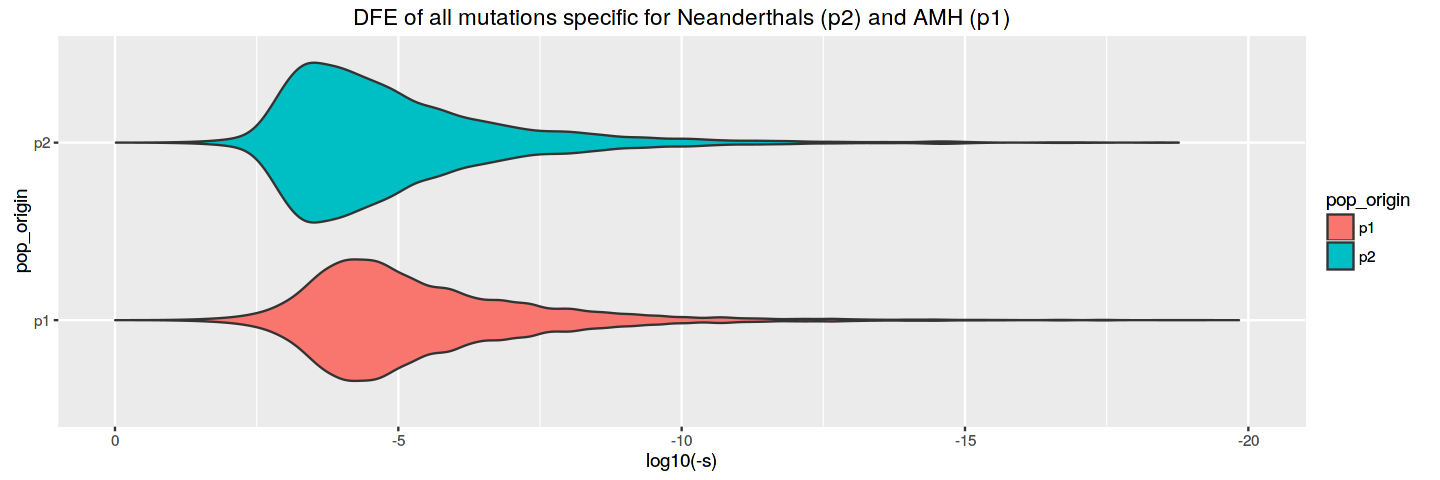

In [249]:
ggplot(rbind(mh_mut, nea_mut)) +
    geom_violin(aes(pop_origin, log10(-s), fill=pop_origin, weight=freq)) +
    coord_flip() +
    ylim(0, -20) +
    labs(title="DFE of all mutations specific for Neanderthals (p2) and AMH (p1)")

Warning message:
“Removed 15 rows containing non-finite values (stat_ydensity).”

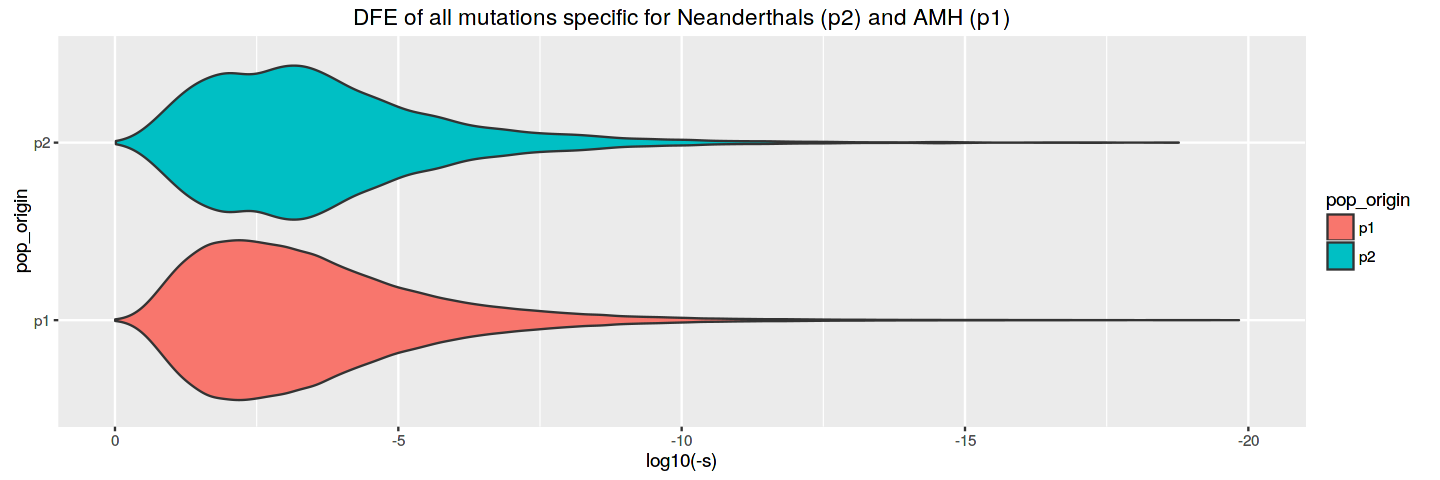

In [176]:
ggplot(rbind(mh_mut, nea_mut), aes(pop_origin, log10(-s), fill=pop_origin)) +
    geom_violin(weight=freq) +
    coord_flip() +
    ylim(0, -20) +
    labs(title="DFE of all mutations specific for Neanderthals (p2) and AMH (p1)")

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”

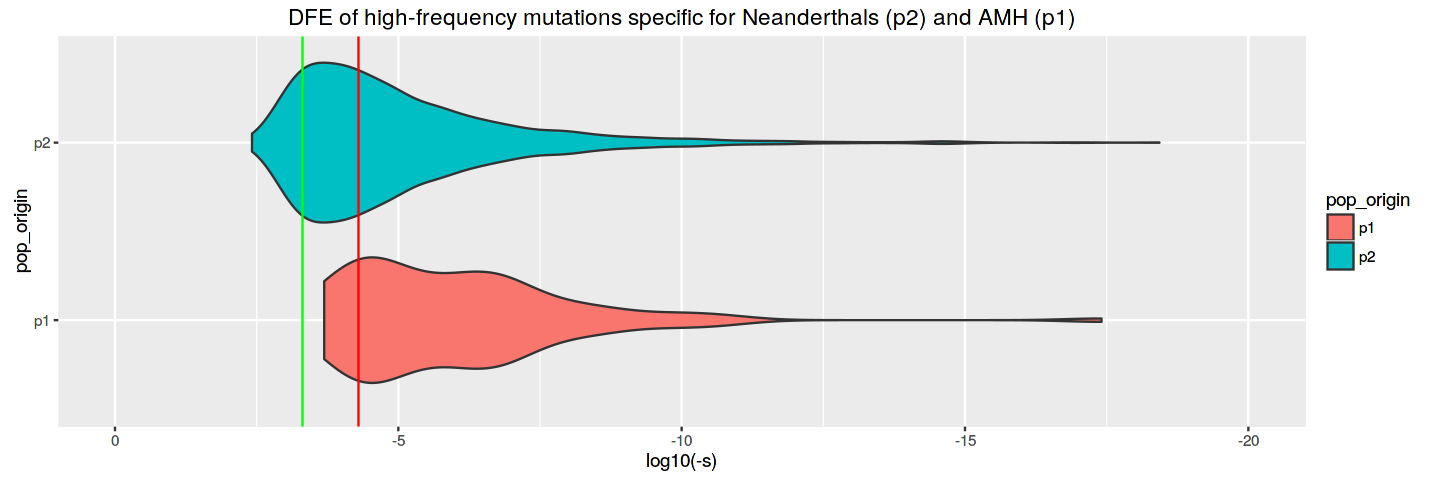

In [178]:
ggplot(rbind(mh_mut, nea_mut) %>% filter(freq > 0.9), aes(pop_origin, log10(-s), fill=pop_origin)) +
    geom_violin() +
    geom_hline(yintercept=log10(1/(2 * c(1000, 10000))), color=c("green", "red")) +
    coord_flip() +
    ylim(0, -20) +
    labs(title="DFE of high-frequency mutations specific for Neanderthals (p2) and AMH (p1)")

In [167]:
rbind(nea_mut, mh_mut) %>% filter(freq > 0.90) %>% group_by(pop_origin) %>% summarize(mean(s))

pop_origin,mean(s)
p2,-2.061737e-04
p1,-2.711784e-05


## Changes in _s_ of introgressed alleles through time

In [121]:
library(parallel)

In [122]:
dfes_list <- mclapply(gens, mc.cores=20, function(gen) {
    slim_file <- read_slim_file(paste0("../simulations/exonic_and_nonexonic/exonic_and_nonexonic__h_0.5__init_nea_0.1__rep_1__dump_gen", gen, ".txt"))
    N <- filter(read_populations(slim_file), pop_id == "p3")$pop_size
    # deleterious mutations originating in the Neanderthals
    introgr_mut <- read_mutations(slim_file, "m0", "p2") %>% mutate(kind="Nea",
                                                                    gen=gen,
                                                                    freq=freq / (2 * N))
    # "control" deleterious mutations originating in the ancestral African AMH population
    control_mut <- read_mutations(slim_file, "m0", "p1", t=50000) %>% mutate(kind="AMH",
                                                                      gen=gen,
                                                                      freq=freq / (2 * N))
    rbind(control_mut, introgr_mut)
})

In [124]:
dfes <- do.call(rbind, dfes_list) %>% mutate(gen=factor(gen))

Warning message:
“Removed 226454 rows containing non-finite values (stat_boxplot).”

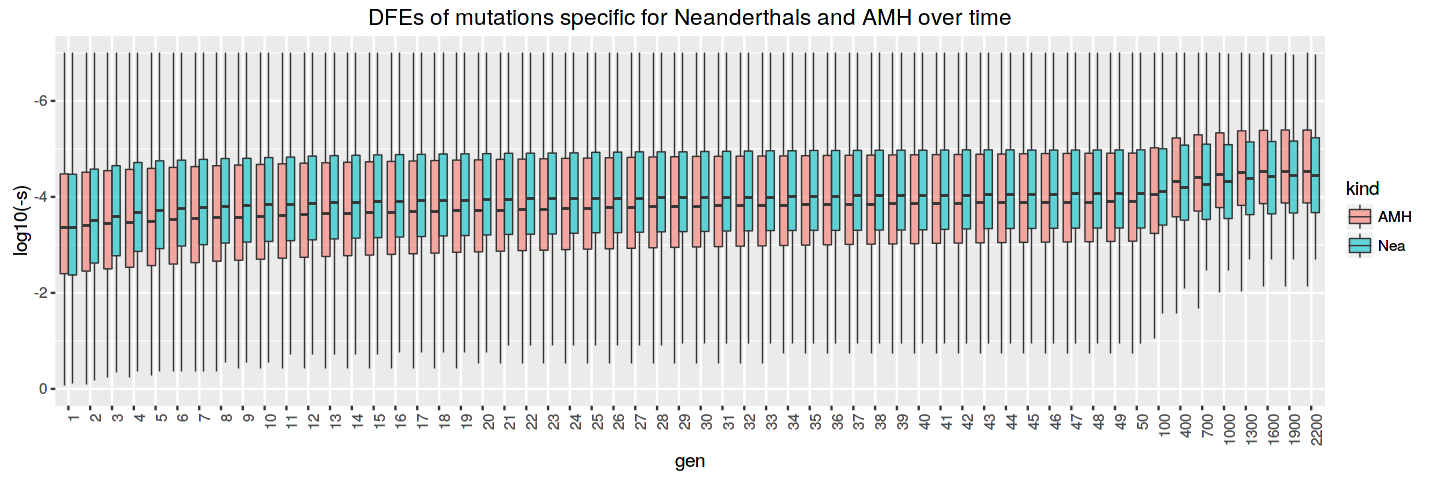

In [132]:
ggplot(dfes, aes(x=gen, y=log10(-s))) +
    geom_boxplot(aes(fill=kind), alpha=0.6, outlier.shape=NA, size=0.3) +
    ylim(0, -7) +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle = 90, hjust=1))

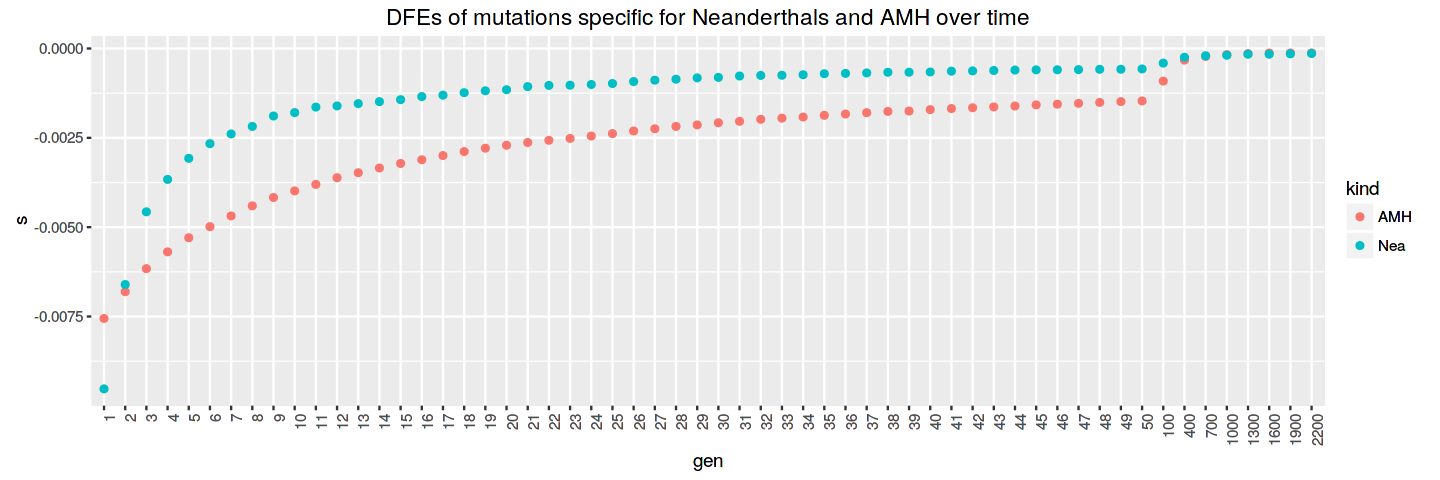

In [175]:
ggplot(group_by(dfes, gen, kind) %>% summarize(s=mean(s)), aes(x=gen, y=s, color=kind)) +
    geom_point() +
    labs(title="DFEs of mutations specific for Neanderthals and AMH over time") +
    theme(axis.text.x = element_text(angle = 90, hjust=1))

Nea. alleles sitting on haplotypes => faster change in DFE of introgressed alleles than non-introgressed (faster selection due to linkage?).

## Comparison of demographic models

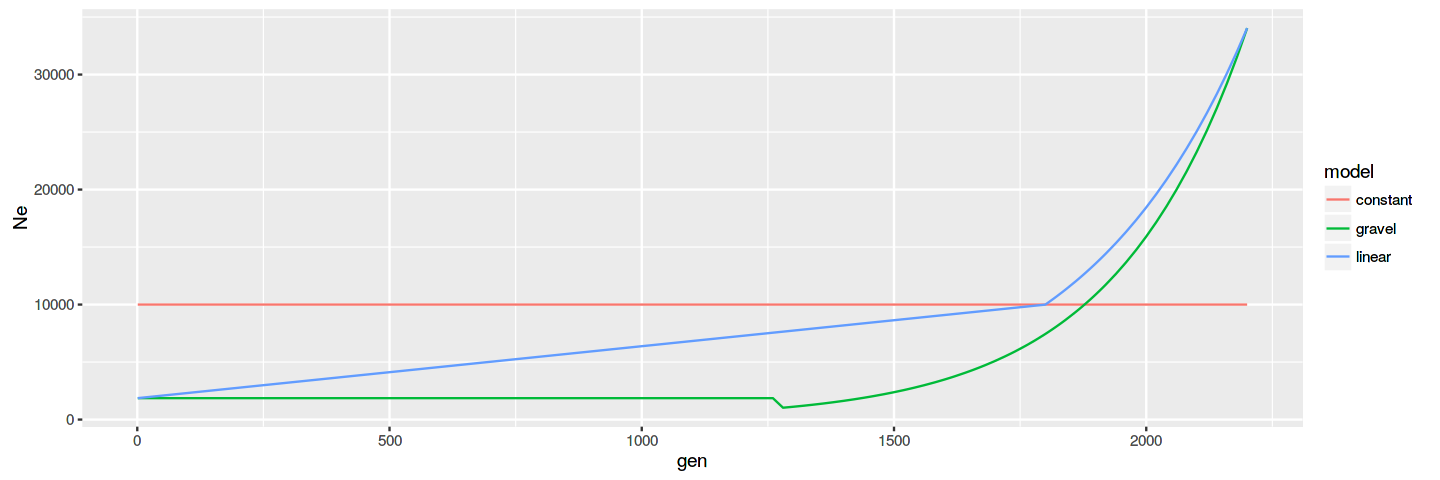

In [273]:
rbind(
    read.table("../simulations/different_models/constant__h_0.5__init_nea_0.1__rep_10__exonic_sites.txt", header=TRUE) %>% mutate(model="constant"),
    read.table("../simulations/different_models/gravel__h_0.5__init_nea_0.1__rep_5__exonic_sites.txt", header=TRUE) %>% mutate(model="gravel"),
    read.table("../simulations/different_models/linear__h_0.5__init_nea_0.1__rep_2__exonic_sites.txt", header=TRUE) %>% mutate(model="linear")
) %>% ggplot(aes(gen, Ne, color=model)) + geom_line()